# Details of Random Exchange Process


In [1]:
import sys
import os
sys.path.insert(0, '../magcolloids')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import HTML, clear_output
import jsonpickle
import scipy.optimize as spo
import scipy.spatial as spa 
import magcolloid as mgc
import matplotlib as mpl
import string as st

from tqdm import tqdm_notebook

ureg = mgc.ureg

idx = pd.IndexSlice

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This is to make plots a bit prettier
plt.rc('text', usetex=True)
mpl.rcParams.update({'figure.dpi': 100})
mpl.rcParams.update({'font.size': 10})

In [3]:
#data_dir = "/Users/aortiza/Desktop/ExchangeData/"
data_dir = "Z:/Dimers/Simulations/MapFrequencies2/"

In [4]:
index = pd.read_csv(data_dir+"index_alpha.dat",sep="\t",index_col=0)
index = index[index.tilt==0]
index.head()

,name,frequency,tilt,alpha,beta
5,Tilt_0.0_deg_freq0.5_2019_03_01_18_33_31,0.500000,0.0,0.000265,0.712803
14,Tilt_0.0_deg_freq0.58_2019_03_01_19_03_18,0.582026,0.0,0.179127,0.452474
20,Tilt_0.0_deg_freq0.67_2019_03_01_19_32_52,0.674972,0.0,0.256798,0.333199
28,Tilt_0.0_deg_freq0.77_2019_03_01_20_02_04,0.779970,0.0,0.272461,0.284078
35,Tilt_0.0_deg_freq0.89_2019_03_01_20_31_08,0.898241,0.0,0.208601,0.386660


## Take a sample dataset with a characteristic exchange state

In [5]:
sample = index.loc[np.abs(index.frequency-5).idxmin()]
sample

name         Tilt_0.0_deg_freq4.87_2019_03_02_03_18_31
frequency                                      4.87339
tilt                                                 0
alpha                                          1.03431
beta                                            2.9152
Name: 148, dtype: object

In [6]:
trj,bnd = mgc.load_trj(os.path.join(data_dir,sample["name"]+".lammpstrj"),slice(0,-1,1))
trj["time"] = trj.index.get_level_values("frame")*1e-4

In [7]:
video = mgc.animate_trj(trj, region = bnd.loc[0].values,
                       radius=1.4, framerate = 26,
                       start = 0, end = 10, step = 3).to_html5_video()
HTML(video)

### Things to check
* Relative number of up and down particles (should be nearly constant).
* Distribution of times between exchanges for a single particle.
* Mean Square Displacement
* Ordering of static particles (How do things look if we remove fast particles?)
* Velocity Distribution

## Relative number of up and down particles

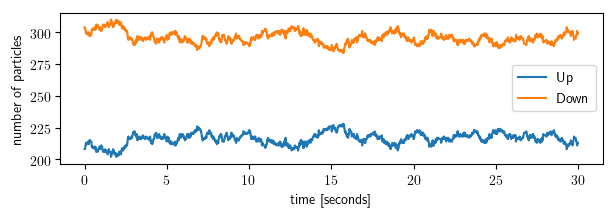

In [8]:
fig = plt.figure(figsize=[7,2])
plt.plot(trj[trj.z>0].groupby("time").z.count())
plt.plot(trj[trj.z<0].groupby("time").z.count())

plt.xlabel("time [seconds]")
plt.ylabel("number of particles")
plt.legend(["Up","Down"])

Above we are plotting the number of particles *Up* and particles *Down*. There are more particles *Down* because we are including gravity.

### What about transfers between up and down sublattices?

In [9]:
trj["state"] = trj.z>0

In [10]:
def state_change(series):
    # ^ is xor
    output = (series)^(series.shift(periods=1)) 
    output.iloc[0] = np.NaN
    return output

In [11]:
trj["state_change"] = trj.state.groupby("id").apply(state_change)

Text(0, 0.5, 'number of shifts')

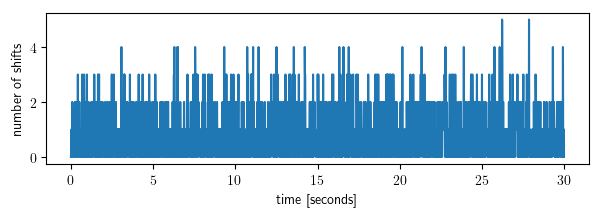

In [12]:
fig = plt.figure(figsize=[7,2])
plt.plot(trj.groupby("time").state_change.sum())

plt.xlabel("time [seconds]")
plt.ylabel("number of shifts")

This is kind of pointless. The number of particles changing from top to bottom (or viceversa) deppends on the frame rate. In any case, this is a kind of rare event. 

## Mean Square Displacement

The mean square displacement might be interesting to compute also differentiated by velocities in case there is a bimodal velocity distribution.

In [13]:
trj_unwrapped = mgc.unwrap_trj(trj[["x","y","z"]],bnd)

In [14]:
%%time
msd = trj.groupby("id").apply(mgc.calculate_msd,lag_frame = np.arange(1,500), col_name = ["x","y","z"], framerate = 75)

Wall time: 3min 11s


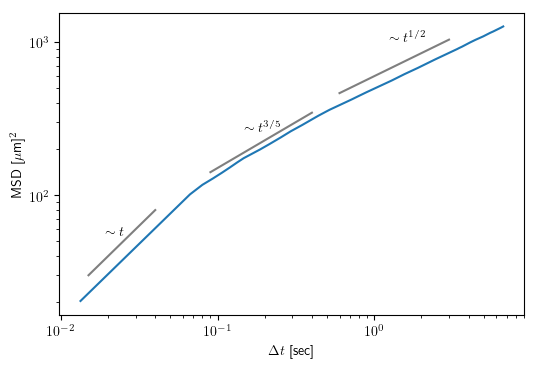

In [15]:
plt.loglog(msd.groupby("dt").mean().sum(axis=1),'-')

plt.xlabel(r"$\Delta{}t$ [sec]")
plt.ylabel(r"MSD [$\mu{}$m]$^2$")

t = np.linspace(1.5e-2,4e-2,3)
plt.loglog(t,2e3*t,color="black", alpha = 0.5)
plt.annotate(r"$\sim t$", (t[1],2e3*t[1]), (-18,0), 
            textcoords = "offset points")

t = np.linspace(6e-1,3e0,3)
plt.loglog(t,6e2*t**(1/2),color="black", alpha = 0.5)
plt.annotate(r"$\sim t^{1/2}$", (t[1],7e2*t[1]), (-18,-10), 
            textcoords = "offset points")

t = np.linspace(9e-2,4e-1,3)
plt.loglog(t,6e2*t**(3/5),color="black", alpha = 0.5)
plt.annotate(r"$\sim t^{3/5}$", (t[1],7e2*t[1]), (-25,20), 
            textcoords = "offset points");

This is the plot of the mean square displacement of all the particles.
The two extremes are not different from what would be expected for a confined system, I think. But the intermediate $t^{3/5}$ is strange. Note that the fit is made *by eye*.

The mean square displacement might be interesting to compute also differentiated by velocities in case there is a bimodal velocity distribution.

## Velocity Distribution

In [16]:
trj_unwrapped["time"] = trj.time

In [17]:
vel = trj_unwrapped.groupby("id")[["x","y","z","time"]].diff()
vel["magnitude"] = np.sqrt((vel[["x","y","z"]]**2).sum(axis=1))/vel["time"]
vel = vel[vel.x.notna()]

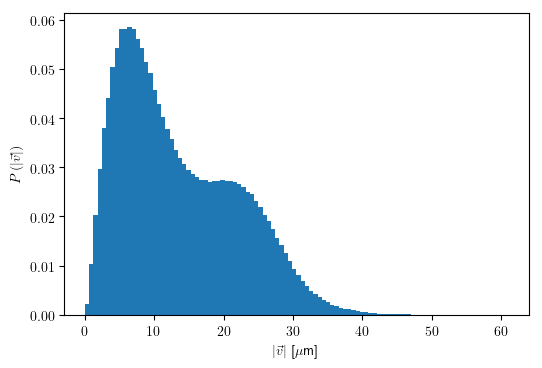

In [18]:
H,v,patches = plt.hist(vel.magnitude,bins = 100, density=True);
plt.xlabel(r"$\left|\vec{v}\right|$ [$\mu$m]");
plt.ylabel(r"$P\left(\left|\vec{v}\right|\right)$");

The above plot is the distribution of velocity magnitudes. 
The bimodal shape is expected. We can see two characteristic velocities also in the video, where one is the velocity of the exchangin particles, and the other is the velocity of static particles. How do these relate to the expected kinetic energy due to temperature? I would expect the first peak to correspond to $v = 2k_bT/m$.

However, I also expected the second peak to be much higher. 

## Divide the system into fast and slow particles

In [19]:
def bimodal(x,mu1,sgm1,A1,mu2,sgm2,A2):
    return x*A1*np.exp(-(x-mu1)**2/2/sgm1**2) + x*A2*np.exp(-(x-mu2)**2/2/sgm2**2)

def gauss(x,mu1,sgm1,A1):
    return x*A1*np.exp(-(x-mu1)**2/2/sgm1**2)

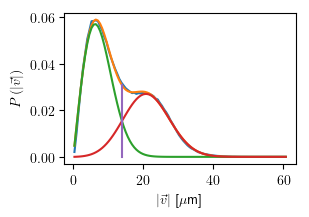

In [20]:
fig = plt.figure(figsize = [3,2])
v_mid = (v[1:]+v[:-1])/2

fit = spo.curve_fit(bimodal,v_mid,H,
              p0 = [5,5,.03,22,5,.06])

plt.plot(v_mid,H)
plt.plot(v_mid,bimodal(v_mid,*fit[0]))
plt.plot(v_mid,gauss(v_mid,*fit[0][:3]))
plt.plot(v_mid,gauss(v_mid,*fit[0][3:]))

mu1, sg1, A1, mu2, sg2, A2 = fit[0]
sq =  sg1*sg2*np.sqrt((mu1-mu2)**2-2*(sg1**2-sg2**2)*np.log(A1/A2)) 
crossing = -((mu1*sg2**2-mu2*sg1**2) + sq)/(sg1**2-sg2**2)

plt.plot([crossing,crossing],[0,bimodal(crossing,*fit[0])])
plt.xlabel(r"$\left|\vec{v}\right|$ [$\mu$m]");
plt.ylabel(r"$P\left(\left|\vec{v}\right|\right)$");

This fit allows us to define a threshold velocity at the crossing between the two distributions. 

In [21]:
vel = trj_unwrapped.groupby("id")[["x","y","z","time"]].diff()
vel["magnitude"] = np.sqrt((vel[["x","y","z"]]**2).sum(axis=1))/vel["time"]

In [22]:
trj["speed"] = vel.magnitude

In [23]:
fig,ax = plt.subplots(1,1,figsize = [3,3])

video_fast = mgc.animate_trj(trj[trj.speed>crossing], region = bnd.loc[0].values,
                       radius=1.4, framerate = 26,
                       start = 0, end = 10, step = 3, ax = ax).to_html5_video()

fig,ax = plt.subplots(1,1,figsize = [3,3])

video_slow = mgc.animate_trj(trj[trj.speed<crossing], region = bnd.loc[0].values,
                       radius=1.4, framerate = 26,
                       start = 0, end = 10, step = 3, ax = ax).to_html5_video()

In [24]:
HTML("""<div class="row">
  <div class="col-sm-5">%s</div>
  <div class="col-sm-5">%s</div></div>
  <div class="row">
  <div class="col-sm-5">fast particles</div>
  <div class="col-sm-5">slow particles</div></div>"""%(video_fast,video_slow))

The videos above show separately the fast particles (normally undergoing exchange) and the slow particles. I'm not sure this is as revealing as I expected it to be. Is there some sort of correlation of the places where exchanges happen? 

There seems to be some kind of network in the slow particles. Like they are a fluid with holes. 

In [25]:
def radial_dist(series,threshold):
    
    def distance(points):
        distances = spa.distance.pdist(points)
        distances = distances[distances<threshold]
        return distances
    
    D = series.groupby("frame").apply(distance)
    return np.array([d for D1 in D for d in D1])

In [26]:
trj_slow = trj[trj.speed<crossing]

In [27]:
frames = trj.index.get_level_values("frame").unique()
D = radial_dist(trj_slow.loc[frames[::10],["x","y","z"]],threshold = 20)

(0, 20)

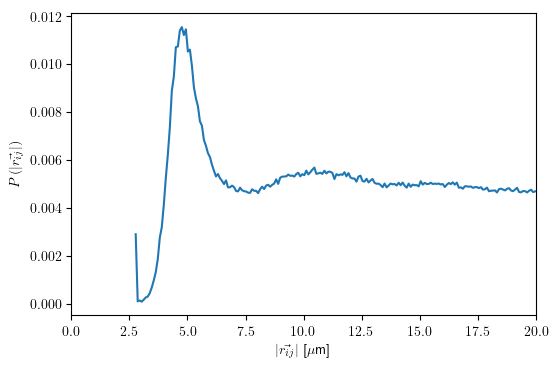

In [28]:
H, r = np.histogram(D,bins=200,density=True);

r_center = (r[1:]+r[:-1])/2
plt.plot(r_center,H/r_center)
plt.xlim(0,20)

plt.xlabel(r"$\left|\vec{r_{ij}}\right|$ [$\mu$m]");
plt.ylabel(r"$P\left(\left|\vec{r_{ij}}\right|\right)$");
plt.xlim(0,20)